In [26]:
## Code sourced from the public domain and modified where required
## https://qiskit-community.github.io/qiskit-optimization/tutorials/06_examples_max_cut_and_tsp.html

import matplotlib.pyplot as plt
import networkx as nx

from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Tsp
from qiskit_algorithms import SamplingVQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import SPSA
from qiskit_algorithms.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer

In [27]:
def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

distance
 [[ 0. 69. 55. 60.]
 [69.  0. 26. 40.]
 [55. 26.  0. 54.]
 [60. 40. 54.  0.]]


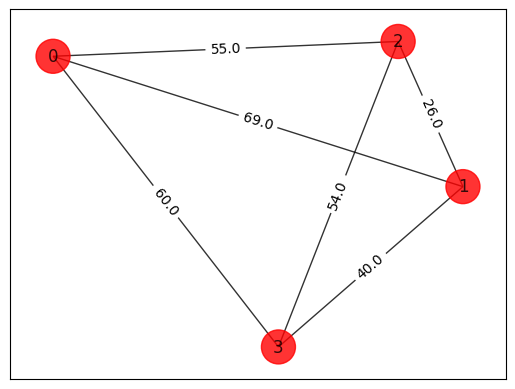

In [28]:
# Generating a graph of 3 nodes
import random

# Number of vertices in G = (V, E) with n = |V|
n = 4

# We need to reslove the entire graph as Hamiltonian cycles represented by n^2 variables 
num_qubits = n**2

tsp = Tsp.create_random_instance(n, seed=random.randint(0,999))
adj_matrix = nx.to_numpy_array(tsp.graph)
print("distance\n", adj_matrix)

colors = ["r" for node in tsp.graph.nodes]
pos = [tsp.graph.nodes[node]["pos"] for node in tsp.graph.nodes]
draw_graph(tsp.graph, colors, pos)

In [29]:
## Brute force approach
do_bf = True

order = (0, 1, 2, 3) Distance = 209.0
order = (0, 2, 1, 3) Distance = 181.0
Best order from brute force = (0, 2, 1, 3) with total distance = 181.0


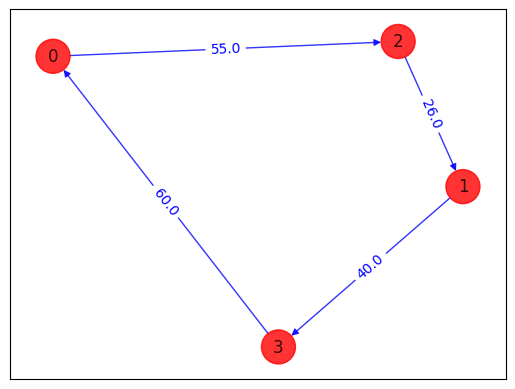

In [30]:
from itertools import permutations


def brute_force_tsp(w, N):
    a = list(permutations(range(1, N)))
    last_best_distance = 1e10
    for i in a:
        distance = 0
        pre_j = 0
        for j in i:
            distance = distance + w[j, pre_j]
            pre_j = j
        distance = distance + w[pre_j, 0]
        order = (0,) + i
        if distance < last_best_distance:
            best_order = order
            last_best_distance = distance
            print("order = " + str(order) + " Distance = " + str(distance))
    return last_best_distance, best_order


best_distance, best_order = brute_force_tsp(adj_matrix, n)
print(
    "Best order from brute force = "
    + str(best_order)
    + " with total distance = "
    + str(best_distance)
)


def draw_tsp_solution(G, order, colors, pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]["weight"])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(
        G2, node_color=colors, edge_color="b", node_size=600, alpha=0.8, ax=default_axes, pos=pos
    )
    edge_labels = nx.get_edge_attributes(G2, "weight")
    nx.draw_networkx_edge_labels(G2, pos, font_color="b", edge_labels=edge_labels)

if (do_bf):
    draw_tsp_solution(tsp.graph, best_order, colors, pos)

In [6]:
# Map the TSP cost function to the Ising Problem
qp = tsp.to_quadratic_program()
print(qp.prettyprint())

Problem name: TSP

Minimize
  19*x_0_0*x_1_1 + 19*x_0_0*x_1_3 + 20*x_0_0*x_2_1 + 20*x_0_0*x_2_3
  + 64*x_0_0*x_3_1 + 64*x_0_0*x_3_3 + 19*x_0_1*x_1_0 + 19*x_0_1*x_1_2
  + 20*x_0_1*x_2_0 + 20*x_0_1*x_2_2 + 64*x_0_1*x_3_0 + 64*x_0_1*x_3_2
  + 19*x_0_2*x_1_1 + 19*x_0_2*x_1_3 + 20*x_0_2*x_2_1 + 20*x_0_2*x_2_3
  + 64*x_0_2*x_3_1 + 64*x_0_2*x_3_3 + 19*x_0_3*x_1_0 + 19*x_0_3*x_1_2
  + 20*x_0_3*x_2_0 + 20*x_0_3*x_2_2 + 64*x_0_3*x_3_0 + 64*x_0_3*x_3_2
  + 37*x_1_0*x_2_1 + 37*x_1_0*x_2_3 + 81*x_1_0*x_3_1 + 81*x_1_0*x_3_3
  + 37*x_1_1*x_2_0 + 37*x_1_1*x_2_2 + 81*x_1_1*x_3_0 + 81*x_1_1*x_3_2
  + 37*x_1_2*x_2_1 + 37*x_1_2*x_2_3 + 81*x_1_2*x_3_1 + 81*x_1_2*x_3_3
  + 37*x_1_3*x_2_0 + 37*x_1_3*x_2_2 + 81*x_1_3*x_3_0 + 81*x_1_3*x_3_2
  + 59*x_2_0*x_3_1 + 59*x_2_0*x_3_3 + 59*x_2_1*x_3_0 + 59*x_2_1*x_3_2
  + 59*x_2_2*x_3_1 + 59*x_2_2*x_3_3 + 59*x_2_3*x_3_0 + 59*x_2_3*x_3_2

Subject to
  Linear constraints (8)
    x_0_0 + x_0_1 + x_0_2 + x_0_3 == 1  'c0'
    x_1_0 + x_1_1 + x_1_2 + x_1_3 == 1  'c1'
    x_2

In [7]:
from qiskit_optimization.converters import QuadraticProgramToQubo

qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
qubitOp, offset = qubo.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: 36416.0
Ising Hamiltonian:
SparsePauliOp(['IIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIZI', 'IIIIIIIIIIIIIZII', 'IIIIIIIIIIIIZIII', 'IIIIIIIIIIIZIIII', 'IIIIIIIIIIZIIIII', 'IIIIIIIIIZIIIIII', 'IIIIIIIIZIIIIIII', 'IIIIIIIZIIIIIIII', 'IIIIIIZIIIIIIIII', 'IIIIIZIIIIIIIIII', 'IIIIZIIIIIIIIIII', 'IIIZIIIIIIIIIIII', 'IIZIIIIIIIIIIIII', 'IZIIIIIIIIIIIIII', 'ZIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIIZIZ', 'IIIIIIIIIIIIIZZI', 'IIIIIIIIIIIIZIIZ', 'IIIIIIIIIIIIZIZI', 'IIIIIIIIIIIIZZII', 'IIIIIIIIIIIZIIIZ', 'IIIIIIIIIIIZIIZI', 'IIIIIIIIIIIZZIII', 'IIIIIIIIIIZIIIIZ', 'IIIIIIIIIIZIIIZI', 'IIIIIIIIIIZIIZII', 'IIIIIIIIIIZZIIII', 'IIIIIIIIIZIIIIZI', 'IIIIIIIIIZIIIZII', 'IIIIIIIIIZIIZIII', 'IIIIIIIIIZIZIIII', 'IIIIIIIIIZZIIIII', 'IIIIIIIIZIIIIIIZ', 'IIIIIIIIZIIIIZII', 'IIIIIIIIZIIIZIII', 'IIIIIIIIZIIZIIII', 'IIIIIIIIZIZIIIII', 'IIIIIIIIZZIIIIII', 'IIIIIIIZIIIIIIIZ', 'IIIIIIIZIIIIIIZI', 'IIIIIIIZIIIIZIII', 'IIIIIIIZIIIZIIII', 'IIIIIIIZIIZIIIII', 'IIIIIIIZZIIIIIII', 'IIIIIIZIIIIIIIIZ', 'IIIIIIZII

In [8]:
do_es = True

In [9]:
if (do_es):
    # solving Quadratic Program using exact classical eigensolver
    exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
    result = exact.solve(qubo)
    print(result.prettyprint())

objective function value: 179.0
variable values: x_0_0=0.0, x_0_1=0.0, x_0_2=1.0, x_0_3=0.0, x_1_0=0.0, x_1_1=0.0, x_1_2=0.0, x_1_3=1.0, x_2_0=1.0, x_2_1=0.0, x_2_2=0.0, x_2_3=0.0, x_3_0=0.0, x_3_1=1.0, x_3_2=0.0, x_3_3=0.0
status: SUCCESS


energy: -36237.0
tsp objective: 179.0
feasible: True
solution: [2, 3, 0, 1]
solution objective: 179.0


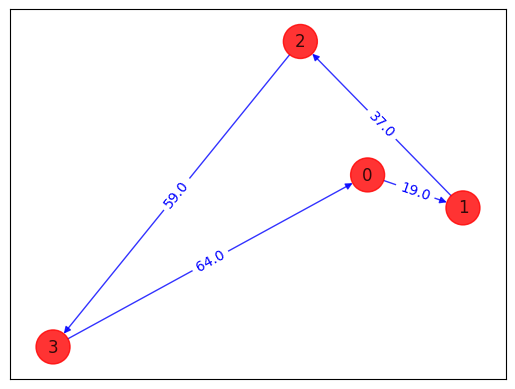

In [10]:
if (do_es):
    # Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
    ee = NumPyMinimumEigensolver()
    result = ee.compute_minimum_eigenvalue(qubitOp)

    print("energy:", result.eigenvalue.real)
    print("tsp objective:", result.eigenvalue.real + offset)
    x = tsp.sample_most_likely(result.eigenstate)
    print("feasible:", qubo.is_feasible(x))
    z = tsp.interpret(x)
    print("solution:", z)
    print("solution objective:", tsp.tsp_value(z, adj_matrix))
    draw_tsp_solution(tsp.graph, z, colors, pos)

In [11]:
# Running on a quantum computer
do_qs = False

In [12]:
algorithm_globals.random_seed = 123
seed = 10598

In [13]:
if (do_qs):
    optimizer = SPSA(maxiter=300)
    ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=5, entanglement="linear")
    vqe = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=optimizer)

    result = vqe.compute_minimum_eigenvalue(qubitOp)

    print("energy:", result.eigenvalue.real)
    print("time:", result.optimizer_time)
    x = tsp.sample_most_likely(result.eigenstate)
    print("feasible:", qubo.is_feasible(x))
    z = tsp.interpret(x)
    print("solution:", z)
    print("solution objective:", tsp.tsp_value(z, adj_matrix))
    draw_tsp_solution(tsp.graph, z, colors, pos)

In [14]:
algorithm_globals.random_seed = 123
seed = 10598

In [15]:
if (do_qs):
    # create minimum eigen optimizer based on SamplingVQE
    vqe_optimizer = MinimumEigenOptimizer(vqe)

    # solve quadratic program
    result = vqe_optimizer.solve(qp)
    print(result.prettyprint())

    z = tsp.interpret(x)
    print("solution:", z)
    print("solution objective:", tsp.tsp_value(z, adj_matrix))
    draw_tsp_solution(tsp.graph, z, colors, pos)